In [1]:
# =====================================
# 1. Imports and Setup
# =====================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageFile
import os

# Allow loading images that might be truncated
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

img_dir = "InputImages"


Using device: cpu


In [2]:
# =====================================
# 6. Dataset and DataLoader
# =====================================

class BrickDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(".png")]
        self.transform = transform
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert("RGB")
        
        label = np.random.uniform(0, 180)  # dummy angle until annotated
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)


In [3]:
def detect_grains_and_angles(
    img_path,
    min_points=50,      # minimum contour points
    min_area=80,        # <-- tune: smallest grain area in pixels
):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not read image at {img_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold
    thresh = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 15, 2
    )

    kernel = np.ones((3, 3), np.uint8)
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(
        clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    grain_data = []
    output = img.copy()

    for i, cnt in enumerate(contours):
        if len(cnt) < min_points:
            continue

        area = cv2.contourArea(cnt)
        if area < min_area:
            continue  # skip tiny specks and huge regions

        # Fit ellipse & get angle
        (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
        grain_data.append({"center": (x, y), "angle": angle})

        cv2.ellipse(output, ((x, y), (MA, ma), angle), (0, 255, 0), 2)
        cv2.putText(output, f"{angle:.1f}°", (int(x), int(y)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return output, grain_data


In [29]:
def major_axis_orientation(cnt):
    """
    Computes the angle (0–180°) between the ellipse major axis and horizontal.
    Uses PCA for robustness.
    """

    pts = cnt.reshape(-1, 2).astype(np.float32)

    # subtract centroid
    mean = np.mean(pts, axis=0)
    pts_centered = pts - mean

    # PCA: covariance of x and y
    cov = np.cov(pts_centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)

    # eigenvector with largest eigenvalue = major axis
    major = eigvecs[:, np.argmax(eigvals)]   # [vx, vy]

    # compute angle from horizontal
    angle = np.degrees(np.arctan2(major[1], major[0]))

    # map angle to range 0–180 degrees
    angle = angle % 180

    return angle, tuple(mean)


In [34]:
def detect_grains_and_angles(
    img_path,
    min_area=120,      # tune: smallest grain area
    max_area=50000,    # tune: largest grain allowed
    kernel_size=3
):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not read image at {img_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # ---------- 1. Strong preprocessing ----------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    gray = cv2.bilateralFilter(gray, 9, 50, 50)  # edge-preserving denoise

    # sharpen structure
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharp = cv2.filter2D(gray, -1, sharpen_kernel)

    # ---------- 2. Thresholding ----------
    adaptive = cv2.adaptiveThreshold(
        sharp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 25, 3
    )

    # Otsu fallback for stability
    _, otsu = cv2.threshold(sharp, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    thresh = cv2.bitwise_or(adaptive, otsu)

    # ---------- 3. Morphology ----------
    k = np.ones((kernel_size, kernel_size), np.uint8)
    bin_clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, k, iterations=2)
    bin_clean = cv2.morphologyEx(bin_clean, cv2.MORPH_CLOSE, k, iterations=2)
    bin_clean = cv2.morphologyEx(bin_clean, cv2.MORPH_OPEN, k, iterations=1)

    # ---------- 4. Distance transform (for watershed) ----------
    dist = cv2.distanceTransform(bin_clean, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.35 * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(bin_clean, sure_fg)

    # markers for watershed
    num_labels, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), markers)
    
    grain_data = []
    output = img.copy()

    # ---------- 5. Extract contours from watershed regions ----------
    for label in range(2, num_labels + 1):  # ignore background
        mask = np.uint8(markers == label) * 255
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not cnts:
            continue
        
        cnt = cnts[0]
        area = cv2.contourArea(cnt)

        if area < min_area or area > max_area:
            continue

        if len(cnt) < 20:
            continue

        # ----- Fit ellipse -----
        (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
        #angle, (x, y) = major_axis_orientation(cnt)

        # ----- Normalize angle -----
        # Convert OpenCV's [0–180] to [-90, +90]
        if angle > 90:
            angle = angle - 180

        grain_data.append({
            "center": (x, y),
            "angle": angle
        })

        # Draw results
        cv2.ellipse(output, ((x, y), (MA, ma), angle), (0,255,0), 2)
        cv2.putText(output, f"{angle:.1f}°", (int(x), int(y)),
                    cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 255, 255), 3)

    return output, grain_data

In [24]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # single continuous output
model = model.to(device)


C:\Users\20vnk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\20vnk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# =====================================
# 7. Training Loop (Orientation Regression)
# =====================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

dataset = BrickDataset(img_dir, transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(loader):.4f}")


Epoch [1/1] - Loss: 10221.8544


Detected 45 grains
First few grain angles (deg): ['78.6', '72.5', '-73.4', '-89.8', '82.5']


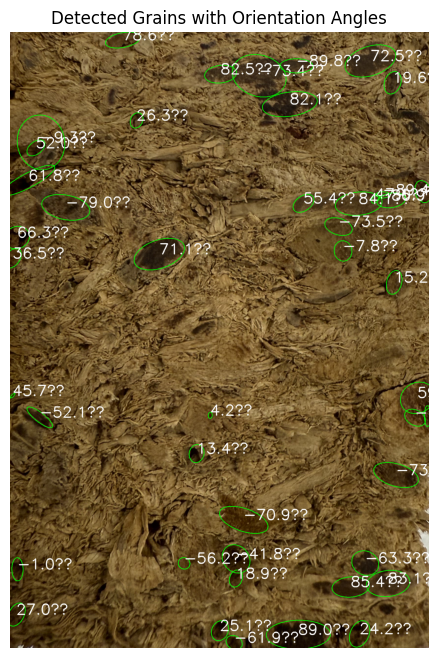

In [35]:
# =====================================
# 2. Test on a single image (SampleBrick)
# =====================================

img_path = r"InputImages\IMG_1120.png"   # or "Sample/SampleBrick.png" depending on OS

annotated_img, grain_data = detect_grains_and_angles(img_path)

print(f"Detected {len(grain_data)} grains")
print("First few grain angles (deg):",
      [f"{g['angle']:.1f}" for g in grain_data[:5]])

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Grains with Orientation Angles")
plt.axis('off')
plt.show()


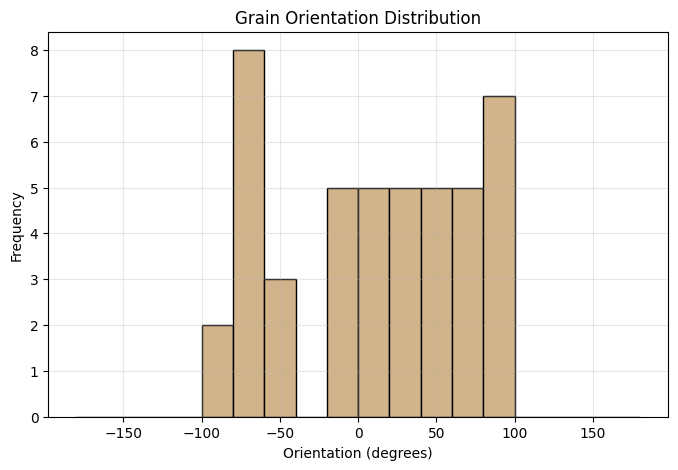

In [28]:
angles = [g["angle"] for g in grain_data]

plt.figure(figsize=(8,5))
plt.hist(angles, bins=18, range=(-180,180), color="tan", edgecolor="black")
plt.title("Grain Orientation Distribution")
plt.xlabel("Orientation (degrees)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# =====================================
# 3. Process a folder of images and save grain orientations
# =====================================
import csv

# Folder with your project images (change as needed)
# If you already have `data_dir` defined earlier, you can also do:
# img_dir = data_dir
img_dir = "InputImages"   # <--- set this to your folder

image_files = sorted([
    f for f in os.listdir(img_dir)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
])
print(f"Found {len(image_files)} images in {img_dir}")

# Folder where annotated images will be saved
output_dir = "grain_orientations_vis"
os.makedirs(output_dir, exist_ok=True)

# CSV to store grain-level orientation data
csv_path = "grain_orientations.csv"

with open(csv_path, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image_name", "grain_index", "x_center", "y_center", "major_axis", "minor_axis", "angle_deg"])
    
    for fname in image_files:
        img_path = os.path.join(img_dir, fname)
        
        annotated_img, grain_data = detect_grains_and_angles(img_path)
        
        # Save annotated image
        out_name = f"annotated_{fname}"
        out_path = os.path.join(output_dir, out_name)
        cv2.imwrite(out_path, annotated_img)
        
        # Save each grain’s data to the CSV
        for i, g in enumerate(grain_data):
            (x, y) = g["center"]
            MA = g["MA"]
            ma = g["ma"]
            angle = g["angle"]
            writer.writerow([fname, i, x, y, MA, ma, angle])
        
        print(f"Processed {fname}: {len(grain_data)} grains")

print("Saved CSV to:", csv_path)
print("Annotated images saved to:", output_dir)


Found 66 images in InputImages
Processed IMG_1101_180.png: 1754 grains
Processed IMG_1102_180.png: 1424 grains
Processed IMG_1103.png: 1361 grains
Processed IMG_1104.png: 1284 grains
Processed IMG_1105.png: 1224 grains
Processed IMG_1106.png: 1591 grains
Processed IMG_1107.png: 1498 grains
Processed IMG_1108.png: 1447 grains
Processed IMG_1109.png: 1400 grains
Processed IMG_1110.png: 1623 grains
Processed IMG_1111.png: 1231 grains
Processed IMG_1112.png: 1419 grains
Processed IMG_1113.png: 1139 grains
Processed IMG_1114.png: 1772 grains
Processed IMG_1115.png: 1102 grains
Processed IMG_1116.png: 2059 grains
Processed IMG_1117.png: 2049 grains
Processed IMG_1118.png: 2298 grains
Processed IMG_1119.png: 1460 grains
Processed IMG_1120.png: 1250 grains
Processed IMG_1121.png: 1610 grains
Processed IMG_1122.png: 1074 grains
Processed IMG_1123.png: 1412 grains
Processed IMG_1124.png: 1353 grains
Processed IMG_1125.png: 1618 grains
Processed IMG_1126.png: 1523 grains
Processed IMG_1127.png: 1

KeyboardInterrupt: 